In [5]:
!pip install pandas numpy matplotlib scipy seaborn


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

plt.style.use("default")
sns.set()


In [7]:
raw = open("/content/historical_data (2).csv", "r").read().splitlines()

rows = [r.split(",") for r in raw if len(r.split(",")) > 10]

trades = pd.DataFrame(rows)
trades.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.34540448,8.95E+14,1.73E+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16,127.68,BUY,02-12-2024 22:50,986.5245955,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.0056,4.43E+14,1.73E+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.0504314,6.60E+14,1.73E+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.05004294,1.08E+15,1.73E+12


In [8]:
trades.columns = [
    "account","symbol","execution_price","size_coin","size_usd","side",
    "timestamp","start_position","event","closed_pnl","tx_hash",
    "trade_id","liquidation","fee","order_id","extra"
]


In [9]:
num_cols = ["execution_price","size_usd","closed_pnl","fee"]
for col in num_cols:
    trades[col] = pd.to_numeric(trades[col], errors="coerce")


In [10]:
trades["timestamp"] = pd.to_datetime(trades["timestamp"], format="%d-%m-%Y %H:%M", errors="coerce")
trades["date"] = trades["timestamp"].dt.date


In [11]:
trades = trades[(trades["size_usd"] > 0) & (trades["execution_price"] > 0)]
trades = trades.drop_duplicates()


In [12]:
trades["is_long"] = trades["side"].str.lower().eq("buy").astype(int)

trades = trades[[
    "account","trade_id","closed_pnl","fee",
    "size_usd","is_long","date"
]]


In [13]:
sentiment = pd.read_csv("/content/fear_greed_index (1).csv")

sentiment["timestamp"] = pd.to_datetime(sentiment["timestamp"], unit="s")
sentiment["date"] = sentiment["timestamp"].dt.date

sentiment["sentiment_regime"] = sentiment["classification"].replace({
    "Extreme Fear": "Fear",
    "Extreme Greed": "Greed"
})

sentiment = sentiment[["date","sentiment_regime"]]
sentiment.head()


,date,sentiment_regime
0,2018-02-01,Fear
1,2018-02-02,Fear
2,2018-02-03,Fear
3,2018-02-04,Fear
4,2018-02-05,Fear


In [14]:
daily_trader = trades.groupby(["date","account"]).agg(
    total_trades=("trade_id","count"),
    daily_pnl=("closed_pnl","sum"),
    win_rate=("closed_pnl", lambda x: (x > 0).mean()),
    median_size=("size_usd","median"),
    total_fees=("fee","sum"),
    long_ratio=("is_long","mean")
).reset_index()

daily_trader.head()


,date,account,total_trades,daily_pnl,win_rate,median_size,total_fees,long_ratio
0,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,9,0.000000,0.000000,1935.950,12.501455,0.777778
1,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,11,-205.434737,0.363636,8677.280,28.300831,0.454545
2,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2,-24.632034,0.000000,5304.975,2.652489,1.000000
3,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,3,0.000000,0.000000,4680.140,3.837189,1.000000
4,2023-12-17,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14,304.982785,0.500000,5368.020,29.069499,0.214286


In [15]:
daily_trader = daily_trader[daily_trader["total_trades"] >= 3]


In [16]:
daily_trader = daily_trader.merge(sentiment, on="date", how="inner")
daily_trader.head()


,date,account,total_trades,daily_pnl,win_rate,median_size,total_fees,long_ratio,sentiment_regime
0,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,9,0.000000,0.000000,1935.95,12.501455,0.777778,Greed
1,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,11,-205.434737,0.363636,8677.28,28.300831,0.454545,Greed
2,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,3,0.000000,0.000000,4680.14,3.837189,1.000000,Greed
3,2023-12-17,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14,304.982785,0.500000,5368.02,29.069499,0.214286,Greed
4,2023-12-19,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,15,1000.538612,0.666667,4728.67,22.900596,0.333333,Greed


In [17]:
low = daily_trader["daily_pnl"].quantile(0.01)
high = daily_trader["daily_pnl"].quantile(0.99)
daily_trader["pnl_capped"] = daily_trader["daily_pnl"].clip(low, high)


In [18]:
activity = daily_trader.groupby("account")["total_trades"].mean()
threshold = activity.quantile(0.75)

daily_trader["segment"] = np.where(
    daily_trader["account"].isin(activity[activity > threshold].index),
    "High Activity", "Low Activity"
)


In [19]:
from scipy.stats import mannwhitneyu

fear = daily_trader[daily_trader["sentiment_regime"]=="Fear"]["pnl_capped"]
greed = daily_trader[daily_trader["sentiment_regime"]=="Greed"]["pnl_capped"]

stat, p = mannwhitneyu(fear, greed)
print("PnL Regime Test p-value:", p)


PnL Regime Test p-value: 0.2636327038476485


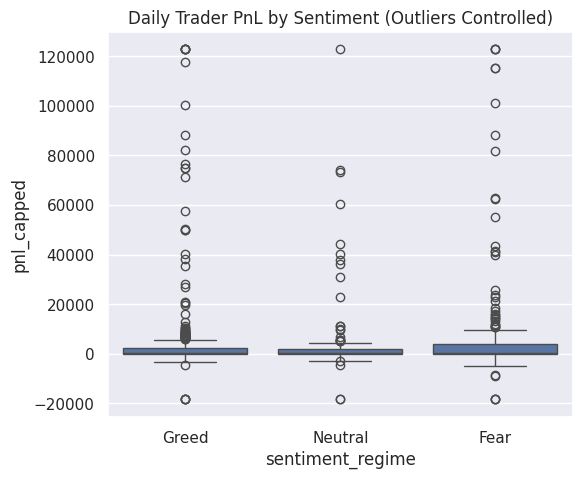

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.boxplot(data=daily_trader, x="sentiment_regime", y="pnl_capped")
plt.title("Daily Trader PnL by Sentiment (Outliers Controlled)")
plt.show()


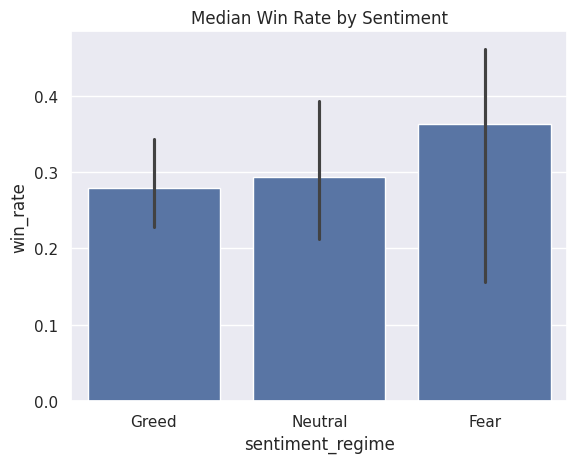

In [21]:
sns.barplot(data=daily_trader, x="sentiment_regime", y="win_rate", estimator=np.median)
plt.title("Median Win Rate by Sentiment")
plt.show()


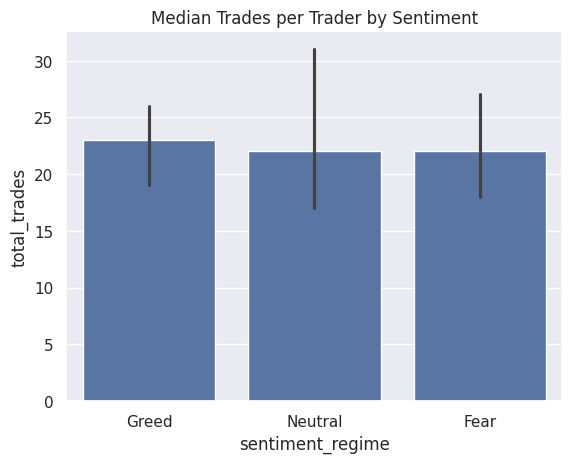

In [22]:
sns.barplot(data=daily_trader, x="sentiment_regime", y="total_trades", estimator=np.median)
plt.title("Median Trades per Trader by Sentiment")
plt.show()


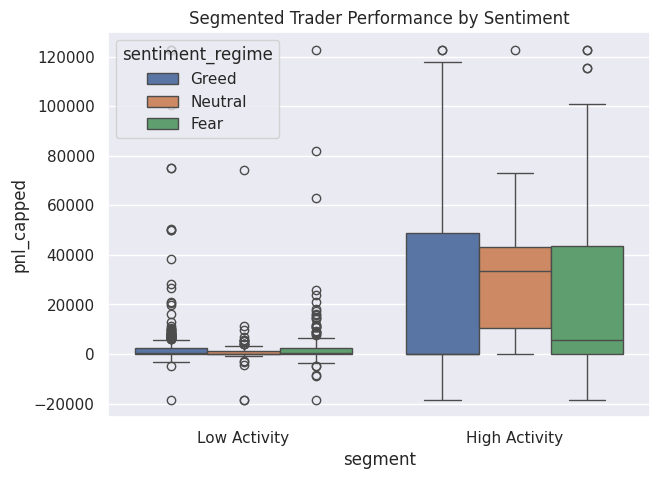

In [23]:
plt.figure(figsize=(7,5))
sns.boxplot(data=daily_trader, x="segment", y="pnl_capped", hue="sentiment_regime")
plt.title("Segmented Trader Performance by Sentiment")
plt.show()


In [29]:
summary_fg = daily_trader[daily_trader["sentiment_regime"].isin(["Fear","Greed"])]

summary_fg = summary_fg.groupby("sentiment_regime").agg(
    median_pnl=("pnl_capped","median"),
    median_winrate=("win_rate","median"),
    median_trades=("total_trades","median")
)

summary_fg


,median_pnl,median_winrate,median_trades
sentiment_regime,,,
Fear,362.477712,0.363636,22.0
Greed,346.713484,0.279221,23.0


In [25]:
from scipy.stats import mannwhitneyu

fear = daily_trader[daily_trader["sentiment_regime"]=="Fear"]["pnl_capped"]
greed = daily_trader[daily_trader["sentiment_regime"]=="Greed"]["pnl_capped"]

stat, p = mannwhitneyu(fear, greed)
print("PnL p-value:", p)


PnL p-value: 0.2636327038476485
